In [9]:
!pip install extinction

import pandas as pd
import numpy as np
import os
import glob
from extinction import fitzpatrick99


DATA_DIR = "mallorn-challenge/"
log_df = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
print(log_df.head(), log_df.shape)

                  object_id       Z  Z_err    EBV SpecType  \
0  Dornhoth_fervain_onodrim  3.0490    NaN  0.110      AGN   
1       Dornhoth_galadh_ylf  0.4324    NaN  0.058    SN II   
2      Elrim_melethril_thul  0.4673    NaN  0.577      AGN   
3        Ithil_tobas_rodwen  0.6946    NaN  0.012      AGN   
4       Mirion_adar_Druadan  0.4161    NaN  0.058      AGN   

                               English Translation     split  target  
0  Trawn Folk (Dwarfs) + northern + Ents (people)   split_01       0  
1    Trawn Folk (Dwarfs) + tree + drinking vessel   split_01       0  
2                  Elves +  lover (fem.)  + breath  split_01       0  
3                    moon +  roof  +  noble maiden  split_01       0  
4            jewel, Silmaril  + father + Wild Man   split_01       0   (3043, 8)


In [10]:
WAVELENGTHS = {
    "u": 3641,
    'g': 4704, 
    'r': 6155, 
    'i': 7504, 
    'z': 8695, 
    'y': 10056
}
def apply_de_extinction(df):
    wl_values = df['Filter'].map(WAVELENGTHS).values.astype(float)
    ebv_values = df['EBV'].values.astype(float)
    unit_extinction = fitzpatrick99(wl_values, 1.0)   
    a_lambda = unit_extinction * (ebv_values * 3.1)
    df['Flux_Real'] = df['Flux'] * (10 ** (a_lambda / 2.5))
    return df 



In [11]:
train_log = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
log_lookup = train_log[['object_id', 'Z', 'EBV', 'target' ]]
all_features =[]
log_lookup

,object_id,Z,EBV,target
0,Dornhoth_fervain_onodrim,3.0490,0.110,0
1,Dornhoth_galadh_ylf,0.4324,0.058,0
2,Elrim_melethril_thul,0.4673,0.577,0
3,Ithil_tobas_rodwen,0.6946,0.012,0
4,Mirion_adar_Druadan,0.4161,0.058,0
...,...,...,...,...
3038,tinnu_gellui_tathar,0.8898,0.042,0
3039,uir_heleg_corf,0.9598,0.042,0
3040,uir_rhosc_law,0.1543,0.024,0
3041,uruk_in_pess,1.1520,0.019,0


In [12]:
for i in range(1,21):
    split_path= os.path.join(DATA_DIR, f"Split_{i:02d}", "train_full_lightcurves.csv") 
    if os.path.exists(split_path):
        print(f"Handling Split path {i:02d}..." )
        chunk_df = pd.read_csv(split_path)
        if i ==1:
            print("This is how the lightcurve data looks like:")
            print(chunk_df.head(), chunk_df.shape)
        chunk_df = chunk_df.merge(log_lookup[['object_id', 'EBV']], on='object_id', how='left')
        if i==1:
            print("After merging EBV values:")
            print(chunk_df.head(), chunk_df.shape)
        chunk_df = apply_de_extinction(chunk_df)
        features = chunk_df.groupby(['object_id', 'Filter'])["Flux_Real"].agg(['mean', 'std', 'min', 'max', 'median'])
        features = features.unstack()
        features.columns = [f'{stat}_{filt}' for stat, filt in features.columns]
        features = features.reset_index()
        all_features.append(features)
        del chunk_df
    else:
        print(f"Split path {i:02d} does not exist." )

# ---Finnal 
if len(all_features) > 0:
    final_train_data = pd.concat(all_features, ignore_index=True)    
    final_train_data = final_train_data.merge(log_lookup[['object_id', 'target', 'Z']], on='object_id', how='left')    
    final_train_data = final_train_data.fillna(0)
    print(final_train_data.head(), final_train_data.shape)
else: 
    print("No features were extracted.")

Handling Split path 01...
This is how the lightcurve data looks like:
                  object_id  Time (MJD)       Flux  Flux_err Filter
0  Dornhoth_fervain_onodrim  63314.4662  -1.630159  0.365777      z
1  Dornhoth_fervain_onodrim  63780.9674  10.499389  0.253867      r
2  Dornhoth_fervain_onodrim  63789.7693   5.866250  1.559241      y
3  Dornhoth_fervain_onodrim  63794.1702   3.903623  0.376854      r
4  Dornhoth_fervain_onodrim  63794.1702   5.226644  0.516864      i (26324, 5)
After merging EBV values:
                  object_id  Time (MJD)       Flux  Flux_err Filter   EBV
0  Dornhoth_fervain_onodrim  63314.4662  -1.630159  0.365777      z  0.11
1  Dornhoth_fervain_onodrim  63780.9674  10.499389  0.253867      r  0.11
2  Dornhoth_fervain_onodrim  63789.7693   5.866250  1.559241      y  0.11
3  Dornhoth_fervain_onodrim  63794.1702   3.903623  0.376854      r  0.11
4  Dornhoth_fervain_onodrim  63794.1702   5.226644  0.516864      i  0.11 (26324, 6)
Handling Split path 02...
Hand

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Am mount of Nan before handling:", final_train_data.isna().sum().sum())
X=final_train_data.drop(columns=['object_id', 'target'])
y=final_train_data['target']
print("Shape of X:", X.shape)
print("features in X:", X.columns.tolist())


Am mount of Nan before handling: 0
Shape of X: (3043, 31)
features in X: ['mean_g', 'mean_i', 'mean_r', 'mean_u', 'mean_y', 'mean_z', 'std_g', 'std_i', 'std_r', 'std_u', 'std_y', 'std_z', 'min_g', 'min_i', 'min_r', 'min_u', 'min_y', 'min_z', 'max_g', 'max_i', 'max_r', 'max_u', 'max_y', 'max_z', 'median_g', 'median_i', 'median_r', 'median_u', 'median_y', 'median_z', 'Z']


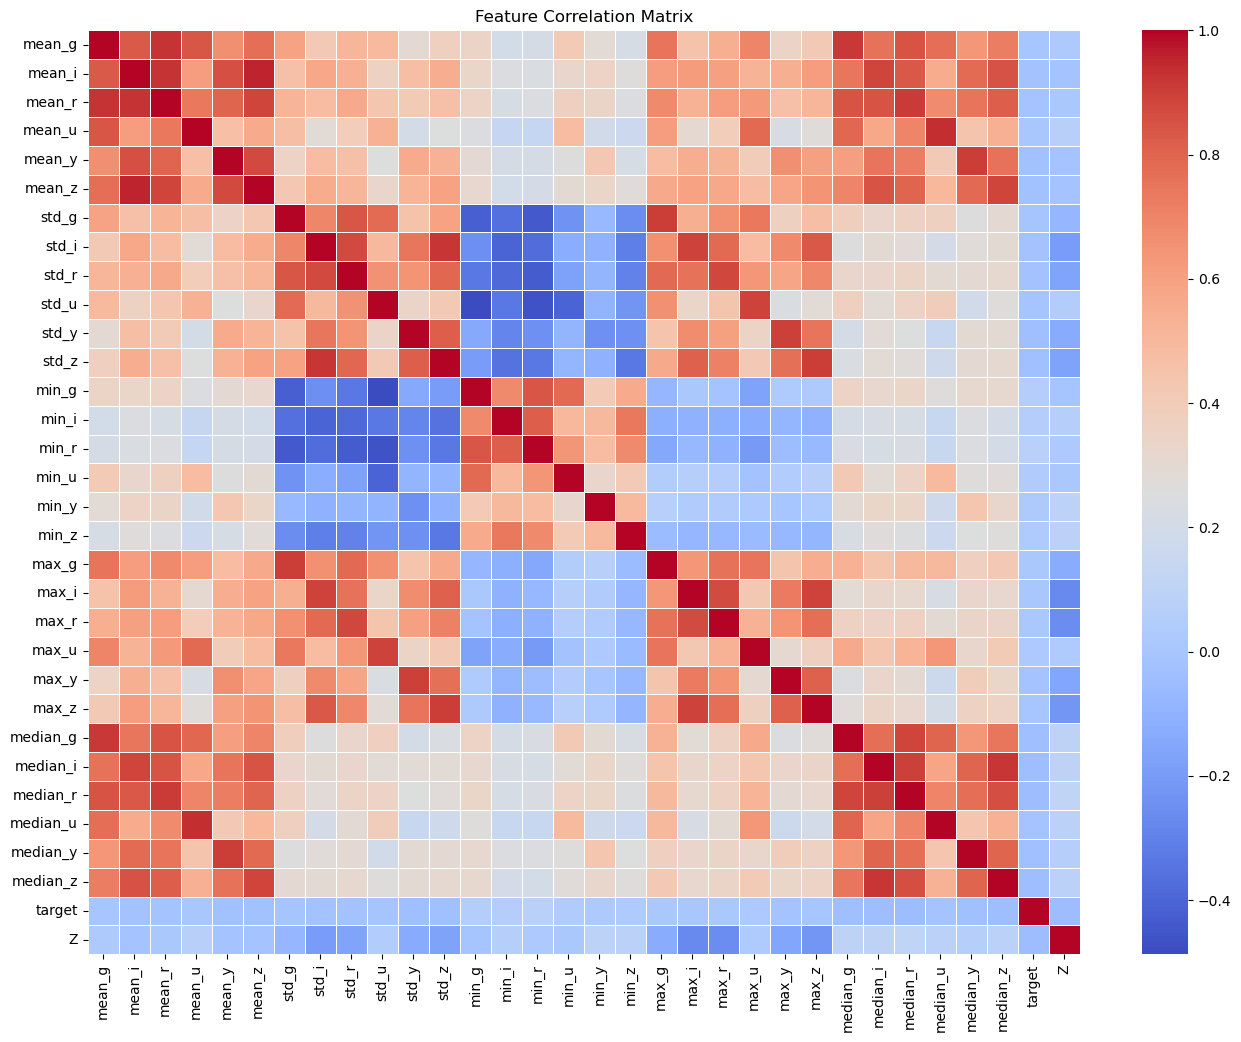

Top 10 strongly correlated features with target:
target      1.000000
min_r       0.071751
min_g       0.053131
min_i       0.053047
median_r    0.048967
Z           0.047886
median_i    0.043560
median_z    0.043339
min_u       0.039535
median_g    0.037406
Name: target, dtype: float64


In [14]:
corr_matrix = final_train_data.drop(columns=['object_id']).corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

print("Top 10 strongly correlated features with target:")
correlation_with_target = corr_matrix['target'].abs().sort_values(ascending=False)
print(correlation_with_target.head(10))


--- KẾT QUẢ VỚI NGƯỠNG 0.2 ---
Confusion Matrix:
[[460 119]
 [  8  22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       579
           1       0.16      0.73      0.26        30

    accuracy                           0.79       609
   macro avg       0.57      0.76      0.57       609
weighted avg       0.94      0.79      0.85       609



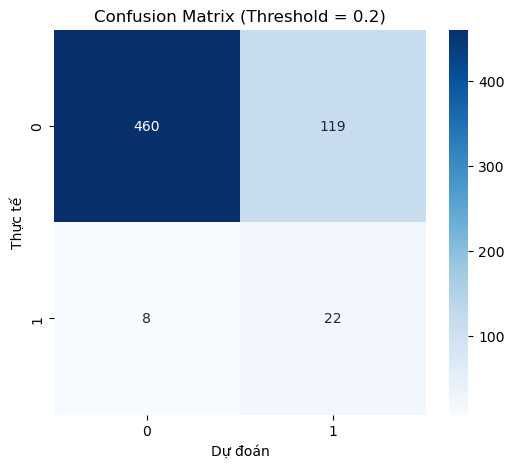

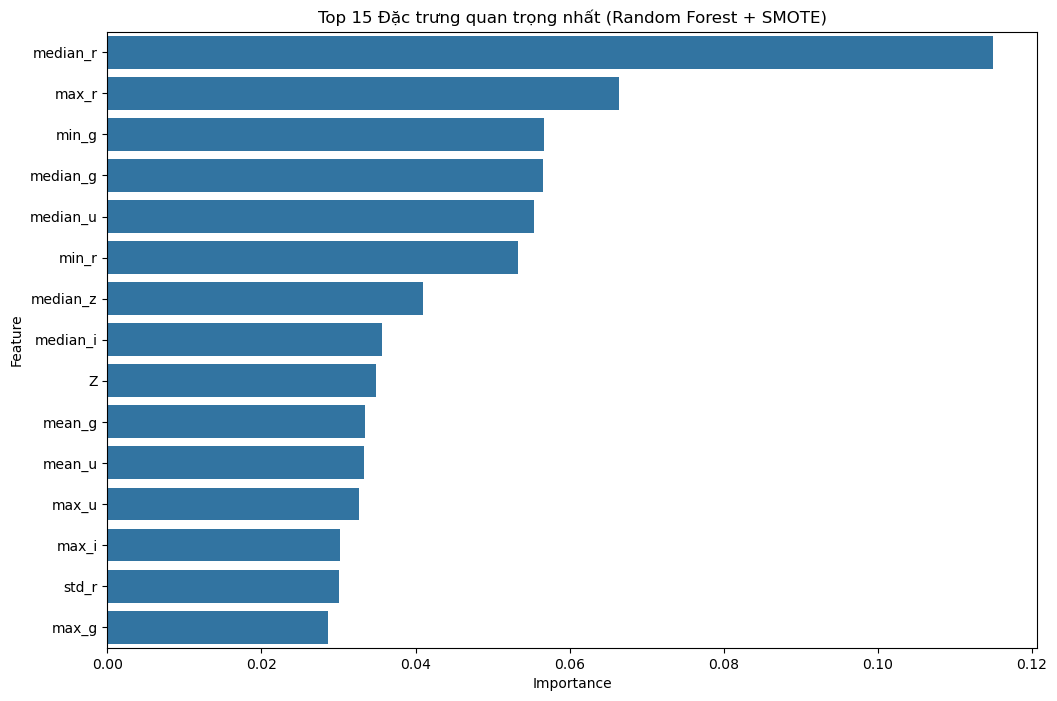

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Chia tập train/test (Giữ nguyên)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Áp dụng SMOTE và Huấn luyện (Giữ nguyên)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
rf_model.fit(X_train_resampled, y_train_resampled)

# --- PHẦN CẦN THAY ĐỔI VÀ BỔ SUNG Ở ĐÂY ---

# 3. Thay vì predict() nhãn 0/1 ngay, hãy lấy xác suất (Probability)
# [:, 1] nghĩa là lấy xác suất của lớp 1 (Lớp mục tiêu hiếm gặp)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# 4. Thiết lập ngưỡng mới (Threshold)
# Mặc định là 0.5. Hãy thử hạ xuống 0.3 hoặc 0.25 để bắt "nhầm còn hơn bỏ sót"
NEW_THRESHOLD = 0.2

# Tạo dự đoán mới dựa trên ngưỡng này
y_pred_new = (y_prob >= NEW_THRESHOLD).astype(int)

# 5. Đánh giá kết quả mới
print(f"--- KẾT QUẢ VỚI NGƯỠNG {NEW_THRESHOLD} ---")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_new)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

# Vẽ lại Confusion Matrix để so sánh
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {NEW_THRESHOLD})')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# --- Phần Feature Importance (Giữ nguyên để vẽ biểu đồ) ---
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Đặc trưng quan trọng nhất (Random Forest + SMOTE)')
plt.show()

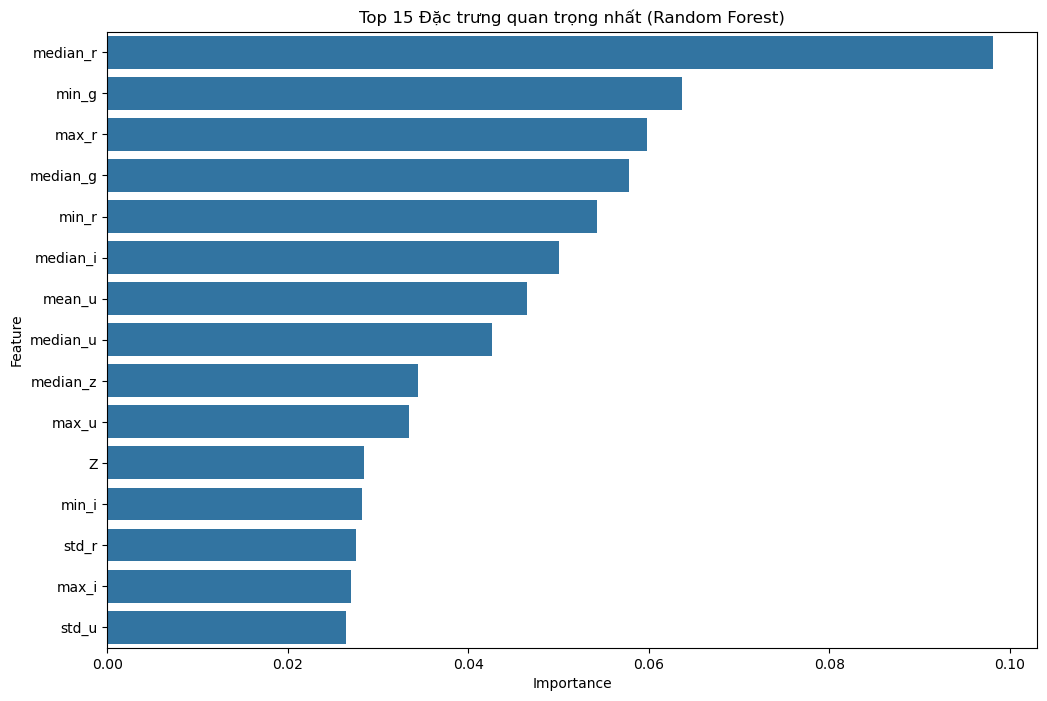

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight='balanced',
                                    random_state=42)
rf_model.fit(X_train, y_train)

# Lấy độ quan trọng của đặc trưng
importances = rf_model.feature_importances_
feature_names = X.columns

# Tạo DataFrame để dễ quan sát
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15)) # Top 15 quan trọng nhất
plt.title('Top 15 Đặc trưng quan trọng nhất (Random Forest)')
plt.show()

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       579
           1       0.37      0.33      0.35        30

    accuracy                           0.94       609
   macro avg       0.67      0.65      0.66       609
weighted avg       0.94      0.94      0.94       609



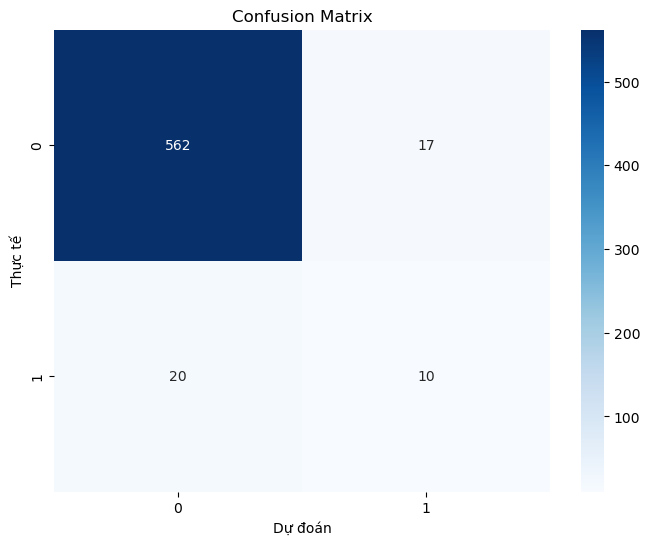

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán trên tập test
y_pred = rf_model.predict(X_test)

# Đánh giá kết quả
print("Báo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred))

# Vẽ Confusion Matrix để xem mô hình hay nhầm lẫn lớp nào
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()
